In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
from zipfile import ZipFile
import time
from datetime import datetime
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

# Data Preprocessing

In [ ]:
combined_faces_zip_path = "/content/drive/My Drive/Age_Classification_with_Faces/DATASETS/combined_faces.zip"

with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping combined_faces.zip')

Done unzipping combined_faces.zip


In [ ]:
combined_faces_zip_path = "/content/drive/My Drive/Age_Classification_with_Faces/DATASETS/combined_faces_train_augmented.zip"

with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping combined_faces_train_augmented.zip')

Done unzipping combined_faces_train_augmented.zip


In [ ]:
train_aug_df = pd.read_csv("/content/drive/My Drive/Age_Classification_with_Faces/images_filenames_labels_train_augmented.csv")
test_df = pd.read_csv("/content/drive/My Drive/Age_Classification_with_Faces/images_filenames_labels_test.csv")

In [ ]:
train_aug_df.drop(columns=['target'], inplace=True)
train_aug_df.head()

,filename,age
0,/content/content/combined_faces_train_augmente...,43
1,/content/content/combined_faces_train_augmente...,71
2,/content/content/combined_faces_train_augmente...,6
3,/content/content/combined_faces_train_augmente...,18
4,/content/content/combined_faces_train_augmente...,25


In [ ]:
test_df.drop(columns=['target'], inplace=True)
test_df.head()

,filename,age
0,/content/content/combined_faces/8_163.jpg,8
1,/content/content/combined_faces/38_66.jpg,38
2,/content/content/combined_faces/40_177.jpg,40
3,/content/content/combined_faces/36_267.jpg,36
4,/content/content/combined_faces/8_349.jpg,8


In [ ]:
train_aug_df.shape

(234400, 2)

In [ ]:
test_df.shape

(10046, 2)

In [ ]:
def class_labels_reassign(age):

    if 1 <= age <= 2:
        return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 20:
        return 2
    elif 21 <= age <= 27:
        return 3
    elif 28 <= age <= 45:
        return 4
    elif 46 <= age <= 65:
        return 5
    else:
        return 6

In [ ]:
train_aug_df['target'] = train_aug_df['age'].map(class_labels_reassign)
test_df['target'] = test_df['age'].map(class_labels_reassign)

In [ ]:
train_aug_df.head()

,filename,age,target
0,/content/content/combined_faces_train_augmente...,43,4
1,/content/content/combined_faces_train_augmente...,71,6
2,/content/content/combined_faces_train_augmente...,6,1
3,/content/content/combined_faces_train_augmente...,18,2
4,/content/content/combined_faces_train_augmente...,25,3


In [ ]:
test_df.head()

,filename,age,target
0,/content/content/combined_faces/8_163.jpg,8,1
1,/content/content/combined_faces/38_66.jpg,38,4
2,/content/content/combined_faces/40_177.jpg,40,4
3,/content/content/combined_faces/36_267.jpg,36,4
4,/content/content/combined_faces/8_349.jpg,8,1


In [ ]:
train_aug_df['target'].value_counts(normalize=True)

4    0.279394
3    0.199829
5    0.167193
0    0.095307
2    0.093643
1    0.084087
6    0.080546
Name: target, dtype: float64

In [ ]:
test_df['target'].value_counts(normalize=True)

4    0.279415
3    0.199781
5    0.167131
0    0.095361
2    0.093669
1    0.084113
6    0.080530
Name: target, dtype: float64

In [ ]:
train_aug_filenames_list = list(train_aug_df['filename'])
train_aug_labels_list = list(train_aug_df['target'])

test_filenames_list = list(test_df['filename'])
test_labels_list = list(test_df['target'])

In [ ]:
train_aug_filenames_tensor = tf.constant(train_aug_filenames_list)
train_aug_labels_tensor = tf.constant(train_aug_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [ ]:
num_classes = 7

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [ ]:
train_aug_dataset = tf.data.Dataset.from_tensor_slices((train_aug_filenames_tensor, train_aug_labels_tensor))
train_aug_dataset = train_aug_dataset.map(_parse_function)
train_aug_dataset = train_aug_dataset.batch(512)    

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.batch(512)    

# CNN Model

In [ ]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200, 200, 1)))    
model.add(AveragePooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(132, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      320       
_________________________________________________________________
average_pooling2d (AveragePo (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
average_pooling2d_1 (Average (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
average_pooling2d_2 (Average (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 256)       2

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir=f"/content/drive/My Drive/Age_Classification_with_Faces/cnn_logs/final_cnn")

In [ ]:
checkpoint = ModelCheckpoint("/content/drive/My Drive/Age_Classification_with_Faces/age_model_checkpoint.h5",monitor='val_accuracy',save_best_only=True,verbose=1)

In [ ]:
hist = model.fit(train_aug_dataset,
                 batch_size=512,
                 validation_data=test_dataset,
                 epochs=60,
                 callbacks=[tensorboard, checkpoint],
                 shuffle=False
                )

Epoch 1/60
458/458 [==============================] - ETA: 0s - loss: 1.8012 - accuracy: 0.3026
Epoch 00001: val_accuracy improved from -inf to 0.34422, saving model to /content/drive/My Drive/Age_Classification_with_Faces/final_cnn_model_checkpoint.h5
458/458 [==============================] - 239s 522ms/step - loss: 1.8012 - accuracy: 0.3026 - val_loss: 1.6542 - val_accuracy: 0.3442
Epoch 2/60
458/458 [==============================] - ETA: 0s - loss: 1.5128 - accuracy: 0.3898
Epoch 00002: val_accuracy improved from 0.34422 to 0.42455, saving model to /content/drive/My Drive/Age_Classification_with_Faces/final_cnn_model_checkpoint.h5
458/458 [==============================] - 167s 365ms/step - loss: 1.5128 - accuracy: 0.3898 - val_loss: 1.4042 - val_accuracy: 0.4245
Epoch 3/60
458/458 [==============================] - ETA: 0s - loss: 1.3421 - accuracy: 0.4530
Epoch 00003: val_accuracy improved from 0.42455 to 0.47362, saving model to /content/drive/My Drive/Age_Classification_with_F

In [ ]:
final_cnn_score = model.evaluate(test_dataset, verbose=1)

20/20 [==============================] - 5s 232ms/step - loss: 0.7465 - accuracy: 0.7789


In [ ]:
final_cnn_labels = model.metrics_names
print(f'CNN model {final_cnn_labels[0]} \t\t= {round(final_cnn_score[0], 3)}')
print(f'CNN model {final_cnn_labels[1]} \t= {round(final_cnn_score[1], 3)}')

CNN model loss 		= 0.746
CNN model accuracy 	= 0.779


In [ ]:
model.save(f"/content/drive/My Drive/Age_Classification_with_Faces/final_age_model.h5", save_format='h5')

In [ ]:
final_cnn_pred = model.predict(test_dataset)
final_cnn_pred = model.argmax(axis=-1)

In [ ]:
conf_mat = confusion_matrix(test_labels_list, final_cnn_pred)
conf_mat

array([[ 929,   21,    0,    0,    7,    1,    0],
       [  33,  774,   26,    2,    6,    2,    2],
       [   1,   50,  792,   35,   62,    1,    0],
       [   5,   16,  230, 1049,  698,    9,    0],
       [   2,   15,   62,  158, 2516,   47,    7],
       [   1,    3,    7,   11,  473, 1034,  150],
       [   0,    3,    4,    0,   23,   48,  731]])

In [ ]:
from visualize import plot_confusion_matrix

Confusion matrix, without normalization
[[ 929   21    0    0    7    1    0]
 [  33  774   26    2    6    2    2]
 [   1   50  792   35   62    1    0]
 [   5   16  230 1049  698    9    0]
 [   2   15   62  158 2516   47    7]
 [   1    3    7   11  473 1034  150]
 [   0    3    4    0   23   48  731]]


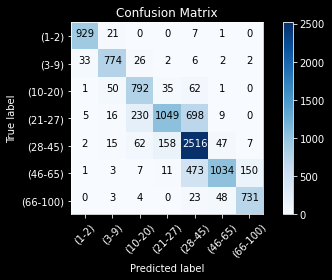

In [ ]:
plt.style.use('dark_background')
plot_confusion_matrix(conf_mat,classes = ["(1-2)","(3-9)","(10-20)","(21-27)","(28-45)","(46-65)","(66-100)"],title="Confusion Matrix")